# ML-Project-1

### A predictive maintenance model for real estate assets that can predict failures using sensor data from building systems. This model effectively trains an agent to schedule maintenance optimally and provides a dashboard for service managers to prioritize repairs.

## ** Phase 1 - Data Acquisition & Preprocessing **

## 1. Load and Process the data

In [5]:
import os
import pandas as pd

cmapss_folder = os.path.join(os.path.expanduser("~"), "Desktop", "CMaps")
train_file = os.path.join(cmapss_folder, "train_FD001.txt")

train_df = pd.read_csv(train_file, sep="\s+", header=None, engine="python")

columns = ["engine_id", "cycle"] + [f"op_setting_{i}" for i in range(1, 4)] + [f"sensor_{i}" for i in range(1, 22)]
train_df.columns = columns

train_df.sort_values(["engine_id", "cycle"], inplace=True)

print(train_df.head())
print(train_df.info())


   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1       -0.0007       -0.0004         100.0    518.67   
1          1      2        0.0019       -0.0003         100.0    518.67   
2          1      3       -0.0043        0.0003         100.0    518.67   
3          1      4        0.0007        0.0000         100.0    518.67   
4          1      5       -0.0019       -0.0002         100.0    518.67   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0    641.82   1589.70   1400.60     14.62  ...     521.66    2388.02   
1    642.15   1591.82   1403.14     14.62  ...     522.28    2388.07   
2    642.35   1587.99   1404.20     14.62  ...     522.42    2388.03   
3    642.35   1582.79   1401.87     14.62  ...     522.86    2388.08   
4    642.37   1582.85   1406.22     14.62  ...     522.19    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    8138.62     8.4195       0.03        392

## 2. Normalize Sensor Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

feature_cols = [col for col in train_df.columns if col.startswith("op_setting_") or col.startswith("sensor_")]

scaler = MinMaxScaler(feature_range=(0, 1))
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])

print(train_df.head())

import joblib

joblib.dump(scaler, 'scaler.pkl')


   engine_id  cycle  op_setting_1  op_setting_2  op_setting_3  sensor_1  \
0          1      1      0.459770      0.166667           0.0       0.0   
1          1      2      0.609195      0.250000           0.0       0.0   
2          1      3      0.252874      0.750000           0.0       0.0   
3          1      4      0.540230      0.500000           0.0       0.0   
4          1      5      0.390805      0.333333           0.0       0.0   

   sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_12  sensor_13  \
0  0.183735  0.406802  0.309757       0.0  ...   0.633262   0.205882   
1  0.283133  0.453019  0.352633       0.0  ...   0.765458   0.279412   
2  0.343373  0.369523  0.370527       0.0  ...   0.795309   0.220588   
3  0.343373  0.256159  0.331195       0.0  ...   0.889126   0.294118   
4  0.349398  0.257467  0.404625       0.0  ...   0.746269   0.235294   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0   0.199608   0.363986        0.0   0.333333

['scaler.pkl']

## 3. Engineer Features (Compute RUL and Rolling Statistics)

In [11]:
max_cycle_df = train_df.groupby("engine_id")["cycle"].max().reset_index()
max_cycle_df.columns = ["engine_id", "max_cycle"]

train_df = train_df.merge(max_cycle_df, on="engine_id")

train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

train_df.drop("max_cycle", axis=1, inplace=True)

print(train_df[["engine_id", "cycle", "RUL"]].head(10))

train_df["sensor_2_roll5"] = train_df.groupby("engine_id")["sensor_2"].rolling(window=5, min_periods=1).mean().reset_index(0, drop=True)

print(train_df[["engine_id", "cycle", "sensor_2", "sensor_2_roll5"]].head(10))


   engine_id  cycle  RUL
0          1      1  191
1          1      2  190
2          1      3  189
3          1      4  188
4          1      5  187
5          1      6  186
6          1      7  185
7          1      8  184
8          1      9  183
9          1     10  182
   engine_id  cycle  sensor_2  sensor_2_roll5
0          1      1  0.183735        0.183735
1          1      2  0.283133        0.233434
2          1      3  0.343373        0.270080
3          1      4  0.343373        0.288404
4          1      5  0.349398        0.300602
5          1      6  0.268072        0.317470
6          1      7  0.382530        0.337349
7          1      8  0.406627        0.350000
8          1      9  0.274096        0.336145
9          1     10  0.150602        0.296386


## 4. Create Time-Series Sequences for LSTM

In [14]:
import numpy as np

def create_sequences(data, window_size=30, step_size=1):
    sequences = []
    labels = []
    for engine_id in data["engine_id"].unique():
        engine_data = data[data["engine_id"] == engine_id].reset_index(drop=True)
        for i in range(0, len(engine_data) - window_size + 1, step_size):
            seq = engine_data.iloc[i:i+window_size][feature_cols].values  
            label = engine_data.iloc[i+window_size-1]["RUL"]               
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_sequences(train_df, window_size=30)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (17731, 30, 24)
y shape: (17731,)


## ** Phase 2: LSTM-based RUL Prediction with Attention Mechanism **

## 1. Define the LSTM Model Architecture

In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        e = K.tanh(K.dot(inputs, self.W) + self.b)  
        e = K.squeeze(e, axis=-1)  
        alpha = K.softmax(e)  
        alpha_expanded = K.expand_dims(alpha, axis=-1)  
        context_vector = inputs * alpha_expanded  
        context_vector = K.sum(context_vector, axis=1)  
        return context_vector

time_steps = X.shape[1]  
num_features = X.shape[2]  

inputs = layers.Input(shape=(time_steps, num_features))
x = layers.LSTM(64, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
context = AttentionLayer()(x)
outputs = layers.Dense(1, activation="linear")(context)

lstm_attention_model = models.Model(inputs=inputs, outputs=outputs)
lstm_attention_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 30, 64)         │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 30, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer                 │ (None, 32)             │            62 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,295 (137.87 KB)

 Trainable params: 35,295 (137.87 KB)

 Non-trainable params: 0 (0.00 B)

## 2. Compile the Model with MSE Loss

In [21]:
lstm_attention_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="mse",
    metrics=["mae"]
)


## 3. Train the Model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = lstm_attention_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)


Epoch 1/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 11221.0127 - mae: 86.6416 - val_loss: 9882.4834 - val_mae: 79.2819
Epoch 2/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 9522.2979 - mae: 77.5294 - val_loss: 8801.2998 - val_mae: 73.6069
Epoch 3/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 8696.5459 - mae: 73.0901 - val_loss: 7896.1025 - val_mae: 68.8842
Epoch 4/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7895.8779 - mae: 69.0761 - val_loss: 7123.8477 - val_mae: 64.9191
Epoch 5/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 7074.8457 - mae: 64.9700 - val_loss: 6468.0957 - val_mae: 61.6011
Epoch 6/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 6344.0391 - mae: 61.3751 - val_loss: 5913.9341 - val_mae: 58.8420
Epoch 7/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5851.9941 - mae: 58.9768 - val_loss: 5448.5605 - val_mae: 56.5861
Epoch 8/50
222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 5282.4937 - mae: 56.0511 - val_loss: 5065.6294 - 

## 4. Evaluate Model Performance and Visualize Learning Curves

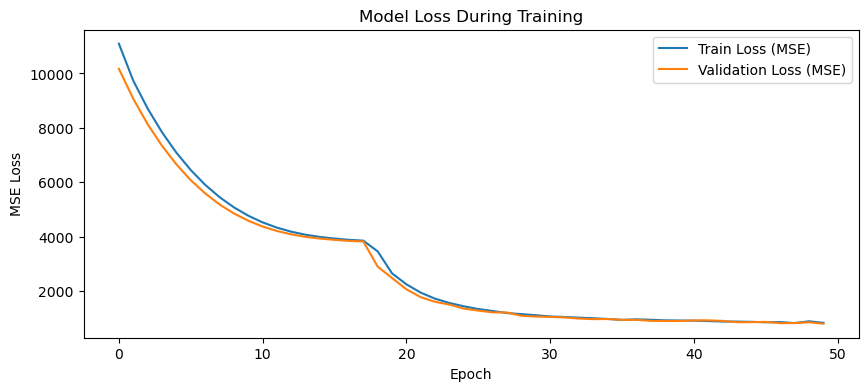

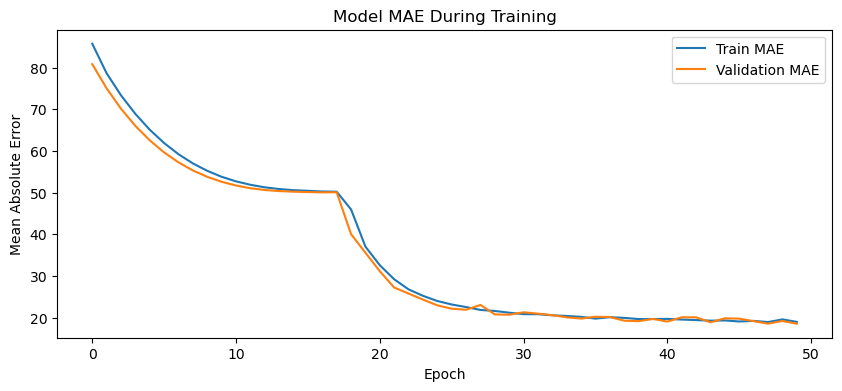

Validation Loss (MSE): 794.3171, Validation MAE: 18.5467


In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(history.history["loss"], label="Train Loss (MSE)")
plt.plot(history.history["val_loss"], label="Validation Loss (MSE)")
plt.title("Model Loss During Training")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(history.history["mae"], label="Train MAE")
plt.plot(history.history["val_mae"], label="Validation MAE")
plt.title("Model MAE During Training")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error")
plt.legend()
plt.show()

val_loss, val_mae = lstm_attention_model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss (MSE): {val_loss:.4f}, Validation MAE: {val_mae:.4f}")

from sklearn.metrics import r2_score

y_pred = lstm_attention_model.predict(X_val).flatten()

r2 = r2_score(y_val, y_pred)
print("R² score:", r2)

## 5. Save the Trained LSTM-Attention Model


In [22]:
lstm_attention_model.save("lstm_rul_model.h5")

# Phase 3: Reinforcement Learning for Maintenance Optimization (PPO)

## 1. Define the Custom RL Environment

In [25]:
!pip install gym

In [26]:
import gym
from gym import spaces
import numpy as np
from gym.utils import seeding  

class MaintenanceEnv(gym.Env):
    def __init__(self, initial_rul=1.0, repair_cost=5.0, failure_penalty=100.0, degrade_rate=0.01, max_cycles=300):
        super(MaintenanceEnv, self).__init__()
        self.initial_rul = initial_rul
        self.repair_cost = repair_cost
        self.failure_penalty = failure_penalty
        self.degrade_rate = degrade_rate
        self.max_cycles = max_cycles
        
        self.action_space = spaces.Discrete(2)  
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(1,), dtype=np.float32)
        self.seed()  
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        done = False
        reward = 0.0
        
        if action == 1:
            reward -= self.repair_cost
            self.current_rul = self.initial_rul
        else:
            self.current_rul -= self.degrade_rate

        self.current_cycle += 1
        
        if self.current_rul <= 0:
            reward -= self.failure_penalty
            self.current_rul = 0.0
            done = True

        if self.current_cycle >= self.max_cycles:
            done = True
        
        if not done:
            reward += 1.0
        
        next_state = np.array([self.current_rul], dtype=np.float32)
        return next_state, reward, done, {}

    def reset(self):
        self.current_cycle = 0
        self.current_rul = self.initial_rul
        return np.array([self.current_rul], dtype=np.float32)
    
    def render(self, mode="human"):
        print(f"Cycle: {self.current_cycle}, RUL: {self.current_rul:.2f}")


## 2. Initialize and Confugure the PPO Agent

In [28]:
!pip install "shimmy>=2.0"

In [29]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env

env = MaintenanceEnv()

vec_env = make_vec_env(lambda: env, n_envs=4)

ppo_agent = PPO("MlpPolicy", vec_env, learning_rate=0.0003, gamma=0.99, verbose=1)


/opt/anaconda3/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device


## 3. Train the PPO Agent

In [31]:
ppo_agent.learn(total_timesteps=100000)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 75       |
|    ep_rew_mean     | -119     |
| time/              |          |
|    fps             | 20623    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 75          |
|    ep_rew_mean          | -97.4       |
| time/                   |             |
|    fps                  | 6827        |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.020479145 |
|    clip_fraction        | 0.52        |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.674      |
|    explained_variance   | -3.58e-07   |
|    learning_rate        | 0.

## 4. Evaluate the Agent's Performance

In [33]:
episodes = 5
for ep in range(episodes):
    state = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _ = ppo_agent.predict(state, deterministic=True)
        state, reward, done, _ = env.step(action)
        total_reward += reward
    print(f"Episode {ep+1}: Total Reward = {total_reward}")

Episode 1: Total Reward = -1.0
Episode 2: Total Reward = -1.0
Episode 3: Total Reward = -1.0
Episode 4: Total Reward = -1.0
Episode 5: Total Reward = -1.0


## 5.  Save the Trained PPO Agent

In [35]:
ppo_agent.save("ppo_maintenance_agent.zip")

## 6. Prepare Test Data

In [62]:
import pandas as pd

txt_file_path = "~/Desktop/CMaps/test_FD002.txt"  
csv_file_path = "~/Desktop/CMaps/test_FD002.csv"  

df = pd.read_csv(txt_file_path, sep="\s+", header=None)  

column_names = ["id", "cycle", "op_setting_1", "op_setting_2", "op_setting_3"] + \
               [f"sensor_{i}" for i in range(1, 22)]  
df.columns = column_names  

df.to_csv(csv_file_path, index=False)

print(f"✅ Successfully converted to CSV: {csv_file_path}")


✅ Successfully converted to CSV: ~/Desktop/CMaps/test_FD002.csv
